<a href="https://colab.research.google.com/github/HeshanDissanayake/SIIM_ISIC_melanoma_classification/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, add, Dropout, Flatten, Dense, Reshape, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from zipfile import ZipFile
import sys
from tensorflow.keras.models import Sequential, load_model
from  tensorflow import keras
from sklearn.metrics import roc_curve, roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!curl 'https://storage.googleapis.com/kaggle-data-sets/687793%2F1205903%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1593229896&Signature=oakT8hz1SQZhsRS9vEDJPB%2Fb%2F1vZt33Eb3qlj9QRDxDy0I7DVyu1HJzvo9m8gZCLoVrALkUwI5Ww3M5udSyZcOdcx7R30Le6RaGIh6mizPRRYpAIgtr2%2Bi5ERAPmXsbRrHFHbeSLuU0FhLYmixbJCSYyHeIFMO5YnjJX9wvG%2BjZ1C2YwNdD1MCdBiDVkjynCOErxa4V240zSZzynUt3gMjbtElg%2BDMHHnNO%2Fn4Xmt3JBMbhaUh58gvZWQkibMcbq2PL50ZSt8JtD1dkbmL0udyxWcDbnJMfYAewArlia7Qrnu5dBLmxMJ4HqZsohe%2BZ96mIlOfa82DprmuRCS2BAfA%3D%3D' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://www.kaggle.com/' -H 'Connection: keep-alive' -H 'Cookie: cuntwars_user_id=xXNhMHwAmW; _ga=GA1.3.1485321816.1568920993' -H 'Upgrade-Insecure-Requests: 1' -H 'TE: Trailers' -o cancer.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2021M  100 2021M    0     0  91.6M      0  0:00:22  0:00:22 --:--:-- 44.4M


In [ ]:
!unzip cancer.zip

In [ ]:
!curl 'https://storage.googleapis.com/kaggle-data-sets/727300%2F1263316%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1593095997&Signature=E8x4ImMAdEKODibWZWS69NMIKbgyOvelexnSYmOM16iAo5iOx3aKeXznNwS29ktuqEnh6KiAvIRRxJxC8gx8CM4MdEUERka%2BWQOzkUEqhfR%2FCMHCoVlP5Kq4iIfJfFM1vsGy3nACvcYuuFpHTcWxAauz8RKw%2FoQngD8lQCuSbv7n5v4mCq6MJ0l1jzW82d33SYbz9a4d2KV2umIxVMaf4zp1ti2ZfqnUaE5PF52PaRDBSGZNcT8Yks5jL40rsR6I2m9Lt%2F1zFNeBHZGALfPtP8KJG4t9RiNzME9UAvNEIye5kbkcIklh%2FZiG2rxoPtFwKYPewM4mgLj4k2%2BN3CTT%2Fg%3D%3D' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://www.kaggle.com/' -H 'Connection: keep-alive' -H 'Cookie: cuntwars_user_id=xXNhMHwAmW; _ga=GA1.3.1485321816.1568920993' -H 'Upgrade-Insecure-Requests: 1' -o external.zip

In [ ]:
!unzip external.zip

In [ ]:
allData = pd.read_csv('/content/train.csv', sep = ',')
df = pd.DataFrame(allData)
malignant = df.groupby(df.target).get_group(1) 
benign = df.groupby(df.target).get_group(0)

malignant_file_names = malignant.image_name.values
benign_file_names = benign.image_name.values

In [ ]:
print(len(malignant_file_names))

584


In [ ]:
# !rm -R /content/300x300 
# !rm -R /content/300x300/test
# !rm -R /content/Data
# !rm -R /content/train/.ipynb_checkpoints
# !rm -R /content/train 
!rm -R /content/Data/train/benign

In [ ]:
!cp -R /content/300x300/train /content/Data/train/benign

In [ ]:
!mkdir Data  
!mkdir /content/Data/train /content/Data/test 
!mkdir /content/Data/train/benign /content/Data/train/malignant /content/Data/test/benign /content/Data/test/malignant

In [ ]:
!mkdir /content/300x300/malignant

In [ ]:
#remove malignants from the source
source = '/content/300x300/train'
traindest = '/content/300x300/malignant'
for i,file in enumerate(malignant_file_names):
  os.system('rm -R %s'%(source+'/'+file+'.jpg'))
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(malignant_file_names))*100, file, traindest))
  sys.stdout.flush()
print("\rComplete")

Complete


In [ ]:
#copy all external images to training folder
dest = '/content/Data/train/malignant/'
for root, dir, files in os.walk('/content/paparere'):
  for i, file in enumerate(files):
    os.system('cp %s %s'%(root+'/'+file, dest + str(i) +'.jpg'))
    sys.stdout.write('\r %d%%'%(100*i/len(files)))

 99%

In [ ]:
#Copy benigns
source = '/content/300x300/train'
traindest = '/content/Data/train/benign' 
testdest = '/content/Data/test/benign' 
trainSize = 30
testSize = 100
benign_file_names_train = benign_file_names[:trainSize]
benign_file_names_test = benign_file_names[trainSize:trainSize+testSize]

for i,file in enumerate(benign_file_names_train):
  os.system('cp -r %s %s'%(source+'/'+file+'.jpg', traindest+'/'+file+'.jpg'))
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(benign_file_names_train))*100, file, traindest))
  sys.stdout.flush()
print("\rComplete")

for i,file in enumerate(benign_file_names_test):
  os.system('cp -r %s %s'%(source+'/'+file+'.jpg', testdest+'/'+file+'.jpg'))
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(benign_file_names_test))*100, file, testdest))
  sys.stdout.flush()
print("\rComplete")

Complete
Complete


In [ ]:
#Copy malignants
source = '/content/300x300/train'
traindest = '/content/Data/train/malignant' 
testdest = '/content/Data/test/malignant' 
testSize = 50
malignant_file_names_train = malignant_file_names[testSize:]
malignant_file_names_test = malignant_file_names[:testSize]

for i,file in enumerate(malignant_file_names_train):
  os.system('cp -r %s %s'%(source+'/'+file+'.jpg', traindest+'/'+file+'.jpg'))
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(malignant_file_names_train))*100, file, traindest))
  sys.stdout.flush()
print("\rComplete")

for i,file in enumerate(malignant_file_names_test):
  os.system('cp -r %s %s'%(source+'/'+file+'.jpg', testdest+'/'+file+'.jpg'))
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(malignant_file_names_test))*100, file, testdest))
  sys.stdout.flush()
print("\rComplete")

Complete
Complete


In [ ]:
trainDatagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=0.8,
                                  zoom_range = 0.1,
                                  fill_mode="nearest",
                                  horizontal_flip=True,
                                  vertical_flip=True)
traingen = trainDatagen.flow_from_directory(directory ='/content/Data/train',
                                       class_mode = 'binary',
                                       target_size = (300, 300),batch_size = 32)


Found 33076 images belonging to 2 classes.


In [ ]:
# create image tensor of test set
labels = []
test_image_tensor = []

for root, dir, images in os.walk('/content/Data/test/benign'):
  for image in images:
    img = plt.imread(root+'/'+image)/255
    test_image_tensor.append(img)
    labels.append(0)

for root, dir, images in os.walk('/content/Data/test/malignant'):
  for image in images:
    img = plt.imread(root+'/'+image)/255
    test_image_tensor.append(img)
    labels.append(1)

test_image_tensor = np.array(test_image_tensor)
labels = np.array(labels).reshape(-1)

In [ ]:
print(test_image_tensor.shape, labels.shape)

(150, 300, 300, 3) (150,)


Inception V3


In [ ]:
from tensorflow.keras.applications import InceptionV3
incep = InceptionV3()

In [ ]:
incep.summary()

In [ ]:

for layer in incep.layers:
  layer.trainable = False



In [ ]:
break_layer_out = incep.get_layer('mixed8').output
x = Conv2D(512,(3,3), activation= 'relu')(break_layer_out)
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.3)(x)
x = Flatten()(x)

x = Dense(1024, activation = 'relu', kernel_regularizer=keras.regularizers.l2(10e-7))(x)
x = Dropout(0.1)(x)

x = Dense(512, activation = 'relu', kernel_regularizer=keras.regularizers.l2(10e-7))(x)
x = Dropout(0.1)(x)

x = Dense(256, activation = 'relu', kernel_regularizer=keras.regularizers.l2(10e-7))(x)
x = Dropout(0.1)(x)

x = Dense(1, activation = 'sigmoid')(x)

net = Model(incep.input, x)
net.summary()


Efficient Net

In [ ]:
!pip install -q efficientnet

In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
effnet = efn.EfficientNetB5(input_shape = (300,300,3), include_top=False)

115515392/115515256 [==============================] - 2s 0us/step


In [ ]:
effnet.summary()

In [ ]:
i = 0
for layer in effnet.layers:
  layer.trainable = False
  i = i +1 
  if i > 450:
    break

In [ ]:
l = effnet.output
l = GlobalAveragePooling2D()(l)
l = Flatten()(l)
l = Dense(1024, activation = 'relu')(l)
l = Dropout(0.2)(l)

l = Dense(256, activation = 'relu')(l)
l = Dropout(0.1)(l)

l = Dense(1, activation = 'sigmoid')(l)
net = Model(effnet.input, l)
net.summary()

compile & training

In [ ]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss = keras.losses.BinaryCrossentropy( label_smoothing= 0.1), metrics = ['binary_crossentropy'])

In [ ]:
history = net.fit(traingen, steps_per_epoch = 1030, epochs = 50, callbacks = [callback])

Epoch 1/50
1030/1030 [==============================] - ETA: 0s - loss: 0.2389 - binary_crossentropy: 0.1050WARNING:tensorflow:Model was constructed with shape (None, 299, 299, 3) for input Tensor("input_1:0", shape=(None, 299, 299, 3), dtype=float32), but it was called on an input with incompatible shape (None, 300, 300, 3).
   roc_auc : 0.9099999999999999
1030/1030 [==============================] - 1065s 1s/step - loss: 0.2389 - binary_crossentropy: 0.1050
Epoch 2/50
1030/1030 [==============================] - 1086s 1s/step - loss: 0.2357 - binary_crossentropy: 0.1003
Epoch 3/50
1030/1030 [==============================] - 1044s 1s/step - loss: 0.2336 - binary_crossentropy: 0.0974
Epoch 4/50
 484/1030 [=============>................] - ETA: 9:02 - loss: 0.2290 - binary_crossentropy: 0.0912

In [ ]:
roc_auc = []
class Callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      predictions = net.predict(test_image_tensor).reshape(-1) 
      auc = roc_auc_score(labels, predictions)
      roc_auc.append(auc)
      dir = '/content/drive/My Drive/cancer/models/EfficientNetB5/v2/auc_%d.h5'%(auc*1000)
      net.save(dir)
      print('   roc_auc :',auc)

        

callback = Callback()

In [ ]:
predictions = net.predict(test_image_tensor).reshape(-1) 
auc = roc_auc_score(labels, predictions)
print(auc)

0.9154


In [ ]:
net = load_model('/content/drive/My Drive/cancer/models/incep/auc_915.h5')

In [ ]:
for layer in net.layers:
  layer.trainable = True


In [ ]:
output = []
for root,dir,files in os.walk('/content/300x300/test'):
  for i,image in enumerate(files):
    image_name = image.strip('.jpg')
    img =  plt.imread(root+'/'+image)
    img = np.reshape(img,(1,300,300,3))
    # img = cv2.resize(img,(299, 299)).reshape(1, 299, 299,3)
    prediction = net.predict(img/255)
    
    print(int((i/len(files))*100),image_name, round(prediction[0][0],5))
    output.append([image_name,round(prediction[0][0],5)])
    # break


In [ ]:

df = pd.DataFrame(output)

In [ ]:
df.to_csv('/content/kagglev31_incep.csv', index=False)

In [ ]:
#  print the propotion of 1s
a = np.array(df[1].values)
b = a > 0.076117
print(np.sum(b)/a.shape[0])

0.36632671644509196


In [ ]:
avg = 0
for i in range(len(output)):
  avg = avg + output[i][1]

avg = avg/len(output)
print(avg)

0.07611705518120497


In [ ]:
img =  plt.imread('/content/train/malignant/ISIC_0351666.jpg')
img = np.reshape(img,(1,300,300,3))
# img = cv2.resize(img,(299, 299)).reshape(1, 299, 299,3)
prediction = net.predict(img/255)
print(prediction)

[[0.98666465]]


In [ ]:
out = output

In [ ]:

np.save('/content/drive/My Drive/cancer/roc_auc_curves/v4.npy', roc_auc)

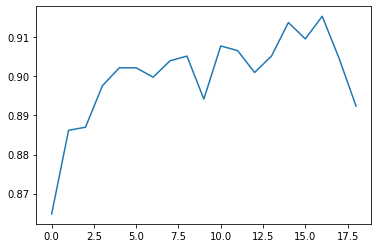

In [ ]:
a = np.load('/content/drive/My Drive/cancer/roc_auc_curves/v1.npy')
plt.plot(roc_auc)